<a href="https://colab.research.google.com/github/Leew309/Leew309/blob/main/Epilepsy_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

using device: cuda
loaded data shape: (11500, 179)
Last column name: y
original y values: [4 1 5 2 3]

class distribution after binary conversion:
y
0    9200
1    2300
Name: count, dtype: int64
Feature matrix shape: (11500, 178)
target vector shape: (11500,)
class weights: tensor([0.6250, 2.5000])

training Fold 1/2
epoch 1/100:
train Loss: 0.2557, val Loss: 0.2947
val Recall: 0.7853
epoch 2/100:
train Loss: 0.1886, val Loss: 0.1606
val Recall: 0.8993
epoch 3/100:
train Loss: 0.1716, val Loss: 0.2426
val Recall: 0.8226
epoch 4/100:
train Loss: 0.1559, val Loss: 0.2225
val Recall: 0.8625
epoch 5/100:
train Loss: 0.1533, val Loss: 0.1479
val Recall: 0.9052
epoch 6/100:
train Loss: 0.1470, val Loss: 0.1394
val Recall: 0.9125
epoch 7/100:
train Loss: 0.1541, val Loss: 0.1704
val Recall: 0.8741
epoch 8/100:
train Loss: 0.1166, val Loss: 0.2573
val Recall: 0.8452
epoch 9/100:
train Loss: 0.1239, val Loss: 0.1835
val Recall: 0.8762
epoch 10/100:
train Loss: 0.1214, val Loss: 0.1746
val Reca

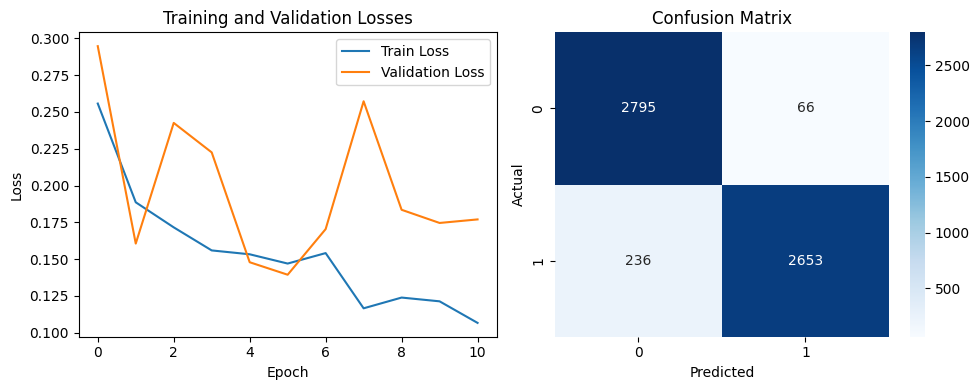


training Fold 2/2
epoch 1/100:
train Loss: 0.2517, val Loss: 0.3163
val Recall: 0.7810
epoch 2/100:
train Loss: 0.1735, val Loss: 0.3181
val Recall: 0.7795
epoch 3/100:
train Loss: 0.1706, val Loss: 0.3324
val Recall: 0.7887
epoch 4/100:
train Loss: 0.1614, val Loss: 0.2464
val Recall: 0.8492
epoch 5/100:
train Loss: 0.1511, val Loss: 0.2200
val Recall: 0.8642
epoch 6/100:
train Loss: 0.1558, val Loss: 0.1926
val Recall: 0.8840
epoch 7/100:
train Loss: 0.1451, val Loss: 0.1496
val Recall: 0.9026
epoch 8/100:
train Loss: 0.1522, val Loss: 0.2037
val Recall: 0.8533
epoch 9/100:
train Loss: 0.1426, val Loss: 0.1734
val Recall: 0.8604
epoch 10/100:
train Loss: 0.1307, val Loss: 0.1462
val Recall: 0.8948
epoch 11/100:
train Loss: 0.1319, val Loss: 0.1706
val Recall: 0.8781
epoch 12/100:
train Loss: 0.1227, val Loss: 0.1978
val Recall: 0.8669
epoch 13/100:
train Loss: 0.1263, val Loss: 0.2197
val Recall: 0.8451
epoch 14/100:
train Loss: 0.1330, val Loss: 0.1827
val Recall: 0.8414
epoch 15/1

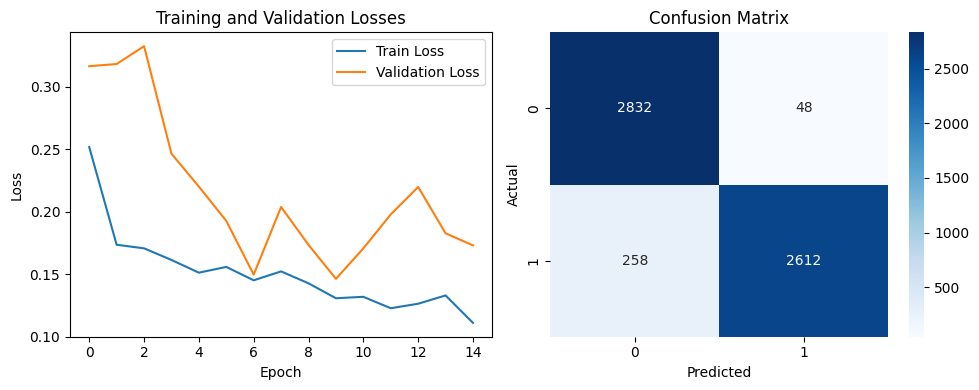


average results across all folds:
AUC: 0.9941 (±0.0009)
RECALL: 0.9142 (±0.0041)


In [ ]:
#!!pip uninstall torch
#!!pip install torch --no-cache-dir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

class EpilepsyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

class ImprovedCNN1D(nn.Module):
    def __init__(self, input_size):
        super(ImprovedCNN1D, self).__init__()
        self.dropout_input = nn.Dropout(0.2)

        # convolutional blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)

        # global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # fully connected
        self.fc1 = nn.Linear(128, 64)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout_fc2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        # input dropout
        x = self.dropout_input(x)

        # conv blocks with dropouts
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        # global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # FC layers with strong dropout
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.dropout_fc2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))

        return x

def prepare_data(file_path):
    """load and prepare the data with proper preprocessing"""
    df = pd.read_csv(file_path, index_col=0)

    # verify data was loaded
    if df.empty:
        raise ValueError(f"no data was loaded from {file_path}")

    print(f"loaded data shape: {df.shape}")

    # check if 'y' is the last column
    last_col = df.columns[-1]
    print(f"Last column name: {last_col}")

    if last_col != 'y':
        df = df.rename(columns={last_col: 'y'})

    # convert to binary properly (1 for seizure, 0 for non-seizure)
    original_y_values = df["y"].unique()
    print(f"original y values: {original_y_values}")

    df["y"] = (df["y"] == 1).astype(int)

    # print class distribution
    print("\nclass distribution after binary conversion:")
    print(df["y"].value_counts())

    # split features and target
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    # calculate class weights
    class_counts = np.bincount(y)
    total_samples = len(y)
    class_weights = torch.FloatTensor([total_samples / (len(class_counts) * count) for count in class_counts])

    print(f"\fFeature matrix shape: {X.shape}")
    print(f"target vector shape: {y.shape}")
    print(f"class weights: {class_weights}")

    return X, y, class_weights




def create_data_loaders(X, y, class_weights, batch_size=32):
    """create weighted samplers and data loaders"""
    # create sample weights
    sample_weights = [class_weights[t] for t in y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # create dataset
    dataset = EpilepsyDataset(X, y)

    # create data loader with weighted sampler
    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    return loader




class EarlyStopping:
    """early stopping implementation"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0





def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100):
    """training loop with validation"""
    train_losses = []
    val_losses = []
    best_recall = 0  # שינוי לשמירת המודל לפי recall
    early_stopping = EarlyStopping(patience=5, min_delta=0.001)

    for epoch in range(num_epochs):
        # training phase
        model.train()
        epoch_train_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # validation phase
        model.eval()
        epoch_val_loss = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)

                epoch_val_loss += loss.item()
                val_preds.extend(outputs.cpu().numpy())
                val_targets.extend(batch_y.cpu().numpy())

        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # calculate validation recall
        val_preds_binary = (np.array(val_preds) >= 0.5).astype(int)
        _, recall, _, _ = precision_recall_fscore_support(val_targets, val_preds_binary, average='binary')

        # learning rate scheduling
        scheduler.step(epoch_val_loss)

        print(f'epoch {epoch+1}/{num_epochs}:')
        print(f'train Loss: {epoch_train_loss:.4f}, val Loss: {epoch_val_loss:.4f}')
        print(f'val Recall: {recall:.4f}')

        # early stopping check
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print("early stopping triggered")
            break

        # save best model based on recall
        if recall > best_recall:
            best_recall = recall
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses


def evaluate_model(model, test_loader, criterion, device):
    """evaluate the model on test set"""
    model.eval()
    test_loss = 0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)

            test_loss += loss.item()
            test_preds.extend(outputs.cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())

    test_loss /= len(test_loader)
    test_preds_binary = (np.array(test_preds) >= 0.3).astype(int)

    # חישוב AUC
    auc = roc_auc_score(test_targets, test_preds)

    # חישוב Recall
    _, recall, _, _ = precision_recall_fscore_support(test_targets, test_preds_binary, average='binary')

    # חישוב מטריצת בלבול
    conf_matrix = confusion_matrix(test_targets, test_preds_binary)

    return {
        'test_loss': test_loss,
        'auc': auc,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }

def plot_results(train_losses, val_losses, conf_matrix):
    """plot training curves and confusion matrix"""
    # plot losses
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # plot confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def main():
    # set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using device: {device}")

    # load and prepare data
    import os
    file_path = '/content/Epileptic Seizure Recognition.csv'
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Could not find data file: {file_path}")

    X, y, class_weights = prepare_data(file_path=file_path)

    # create k-fold cross validation splits
    n_splits = 2
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # store results for each fold
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\ntraining Fold {fold + 1}/{n_splits}")

        # split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # create data loaders
        train_loader = create_data_loaders(X_train, y_train, class_weights)
        val_loader = create_data_loaders(X_val, y_val, class_weights)

        # initialize model and training components
        model = ImprovedCNN1D(X.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(
                                model.parameters(),
                                lr=0.001,
                                weight_decay=0.1,
                                betas=(0.9, 0.999))

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                      optimizer,
                      mode='min',
                      factor=0.5,
                      patience=3,
                      verbose=True)


        # train model
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion,
            optimizer, scheduler, device
        )

        # evaluate on validation set
        val_results = evaluate_model(model, val_loader, criterion, device)
        fold_results.append(val_results)

        # plot results for this fold
        plot_results(train_losses, val_losses, val_results['confusion_matrix'])

    # print average results across folds
    print("\naverage results across all folds:")
    metrics = ['auc', 'recall']
    for metric in metrics:
        values = [result[metric] for result in fold_results]
        print(f"{metric.upper()}: {np.mean(values):.4f} (±{np.std(values):.4f})")

if __name__ == "__main__":
    main()

In [1]:
!git clone https://github.com/Leew309/epilepsy-cnn.git

Cloning into 'epilepsy-cnn'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.


In [8]:
!mv /content/Epilepsy_CNN.ipynb .


mv: cannot stat '/content/Epilepsy_CNN.ipynb': No such file or directory
